In [2]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pylab as plt
from icecream import ic
import numpy as np
import math
import os
import seaborn as sns
import numpy as np
import sys
sys.path.insert(0, r'..\tools')
from smooth import smooth,ins_smooth
from sort_group import sort_arr2

In [3]:
np.set_printoptions(suppress=True)

def zscore(baseline_data, values_data):
    mean = np.mean(baseline_data)  # 前一秒平均值
    var = np.std(baseline_data, ddof=1)  # 前一秒的标准差
    zscore_data = (values_data - mean) / var
    return zscore_data

In [4]:
def inscopix_heatmap(data,file,LorR):

    frequncey = (np.array(pd.DataFrame(data['C2'][0][0][9]).values.tolist()).reshape(1, -1)[0])[1]

    print('细胞频率为：%s'%frequncey)

    ##通用，按照细胞来读取频率

    num = round(second / float(frequncey))
    baseline_num = round(baseline / float(frequncey))

    ## sleep
    # num = round(second / 0.0695)
    # baseline_num = round(baseline / 0.0695)

    ## sleep 单个状态
    # num = round(second / 0.0078)
    # baseline_num = round(baseline / 0.0078)

    ## 视动前庭
    # num = round(second / 0.0909)
    # baseline_num = round(baseline / 0.0909)

    print('当秒数设置为{}时，每个marker后寻找到的点有{}个。'.format(second, num))

    keys = data.keys()
    cell_list = [item for item in keys if 'C' in item]

    # marker_list = ['M1']
    marker_times = data[marker_list[LorR]]  # 0时：从左到右，1时从右到左
    marker = np.array(pd.DataFrame(marker_times[0][0][4]).values.tolist()).reshape(1, -1)[0]
    print(marker)

    cell_map, y,cell_map_trials = [], [],[]
    for i in range(len(cell_list)):
        heatmap_data = []
        for markeri in marker:
            celli = cell_list[i]
            values_data = pd.DataFrame(data[celli][0][0][8], columns=['a'])['a'].tolist()
            times_data = pd.DataFrame(data[celli][0][0][9], columns=['a'])['a'].tolist()
            # indexi为距离markeri最近的下标

            ### 所有的数都减去Mark，然后取绝对值，然后从这一堆数据中取一个最小值
            #################################
            # print(list(np.array(times_data) - markeri),min(list(np.array(times_data) - markeri)))
            # indexi = list(np.array(times_data) - markeri).index(min(list(np.abs(np.array(times_data) - markeri))))
            ##################################

            time_differencedata = np.array(list(times_data - markeri))
            mindata = np.min(time_differencedata[np.where(time_differencedata >= 0)])
            indexi = list(time_differencedata).index(mindata)
            # print(file,celli,indexi,markeri)

            heatmap_datai = []
            baseline_data = []  # 存放前一秒的数据
            for datai in range(baseline_num):
                baseline_data.append(values_data[indexi - datai])
            for datai in range(baseline_num-1,-1,-1):
                zscore_data = zscore(baseline_data, baseline_data[datai])
                heatmap_datai.append(zscore_data)
            for datai in range(num):
                zscore_data = zscore(baseline_data, values_data[indexi + datai])
                heatmap_datai.append(zscore_data)

            heatmap_data.append(heatmap_datai)  # 每个细胞的heatmap_data应该是（marker数，num）

        if np.where(np.array(heatmap_data) > 500)[0].shape[0] > 0:
            print('细胞{}z-score存在大于100，过滤掉'.format(cell_list[i]))
        elif np.where(np.array(heatmap_data) > -500)[0].shape[0] == 0:
            print('细胞{}z-score全部小于-100，过滤掉'.format(cell_list[i]))
        else:

            cell_map.append(np.array(heatmap_data).sum(axis=0) / len(marker))
            cell_map_trials.append(heatmap_data)

            y.append(file+'_'+ cell_list[i])  ####y的末尾追加一个元素

        # cell_map = np.array(cell_map).sum(axis=0) / len(marker)  # axis=0计算每一列的和
        # print(baseline_data)

    if len(cell_map) == 0:
        print('数据全部不符合所定义的规则')
        return ""
    else:
        print('数据中的最大值是{}，最小值是{}'.format(np.max(cell_map), np.min(cell_map)))

        # 改变热图的bar,vmax最大值
        xticklabels = [-1]

        for item in range(1, baseline_num):
            xticklabels.append('')
        for item in range(0, num):
            if item % baseline_num == 0:
                xticklabels.append(item / baseline_num)
            else:
                xticklabels.append('')
        return cell_map,y,cell_map_trials

In [5]:
def sortedByYourself(dic_list,list):
    result=[]
    for x in list:
        for dic_data in dic_list:
            if x==dic_data['y']:
                result.append(dic_data)
    return result

In [6]:
### 排序
def sort_mean(cell_map,y,cell_map_trial,percentage,P_classify_threshold,N_classify_threshold,wantedList):   ###main函数中写的变量必须加到这个函数里面  不然无法访问

    dic_list = []   #创建list
    cell_zscore_mean = []
    # print(len(cell_map),len(y))
    frequncey = (np.array(pd.DataFrame(data['C2'][0][0][9]).values.tolist()).reshape(1, -1)[0])[1]
    ic('-------------',frequncey)
    # frequncey = (np.array(pd.DataFrame(data['Chan_2'][0][0][9]).values.tolist()).reshape(1, -1)[0])[1]
    startpoint = int(baseline // frequncey)
    ### 数组array有行和列之分，和矩阵类似，但是list没有列，只是一个行，list有长度[[],[]]
    for index in range(len(cell_map)):   ##len是长度，为了遍历里面的每一个cell
        dic = {}
        mean = np.mean(np.array(cell_map[index][startpoint:]))

        # positive   ### np.where后面需要用array，后面加一个条件np.where可以找到符合这个条件的数据下标，但是要加len...[0]可以读取出符合条件数据下标的个数
        p = len(np.where(np.array(cell_map[index][startpoint:]) >= P_classify_threshold)[0]) > int(len(cell_map[index][startpoint:]) * percentage/100)
        # p = len(np.where(np.array(cell_map[index][startpoint:]) >= P_classify_threshold)[0]) > 4
        # print(int(len(cell_map[index][startpoint:]) * percentage/100))
        p_len = len(np.where(np.array(cell_map[index][startpoint:]) >= P_classify_threshold)[0]) - len(cell_map[index][startpoint:]) * percentage/100

        # p_len = len(np.where(np.array(cell_map[index][startpoint:]) >= P_classify_threshold)[0])
        # negative
        n = len(np.where(np.array(cell_map[index][startpoint:]) <= N_classify_threshold)[0]) > int(len(cell_map[index][startpoint:]) * percentage/100)
        # n = len(np.where(np.array(cell_map[index][startpoint:]) <= N_classify_threshold)[0]) > 4
        n_len = len(np.where(np.array(cell_map[index][startpoint:]) <= N_classify_threshold)[0]) - len(cell_map[index][startpoint:]) * percentage / 100
        # n_len = len(np.where(np.array(cell_map[index][startpoint:]) <= N_classify_threshold)[0])
        if  p == True:
            dic['classify_threshold'] = 'positive'
        elif n == True:
            dic['classify_threshold'] = 'negative'
        else:
            dic['classify_threshold'] = 'no response'

        dic['mean'] = mean
        dic['cell'] = cell_map[index]    ###cell_map中的第index个数据对应cell
        dic['cell_trials'] = cell_map_trial[index]    ###cell_map中的第index个数据对应cell
        dic['y'] = y[index]
        dic['p_len'] = p_len
        dic['n_len'] = n_len

        dic_list.append(dic)
        # list(cell).append(mean)   ###append是list的函数

    if len(wantedList) > 0:
        dic = sortedByYourself(dic_list,wantedList)
    else:
        dic = sorted(dic_list, key=lambda x:x['mean'], reverse=True)   ##sorted是排序函数，必须用list
    ## 告诉sorted按照mean来排序   第一个x代表list里面的每一项   第二个x表示按照mean进行排序

    cell_map,y,cell_map_trial,pLen,nLen = [],[],[],[],[]
    for i in range(len(dic)):
        cell_map.append(dic[i]['cell'])
        cell_map_trial.append(dic[i]['cell_trials'])
        cell_zscore_mean.append(dic[i]['mean'])
        y.append(dic[i]['y'])
        pLen.append(dic[i]['p_len'])
        nLen.append(dic[i]['n_len'])
    # ic(pLen,nLen)

    ##########################################
    # 画单独的positive或者negative或者 no response
    # for i in range(len(dic)):
    #     if dic[i]['classify_threshold'] == 'positive':      #### positive可以修改为negative，或者no response
    #     # if dic[i]['classify_threshold'] == 'no response':
    #     # if dic[i]['classify_threshold'] == 'negative':
    #         cell_map.append(dic[i]['cell'])
    #         cell_zscore_mean.append(dic[i]['mean'])
    #         y.append(dic[i]['y'])

    # for i in range(len(dic)):
    #     # if dic[i]['classify_threshold'] == 'positive':      #### positive可以修改为negative，或者no response
    #     if dic[i]['classify_threshold'] == 'no response':
    #     # if dic[i]['classify_threshold'] == 'negative':
    #         cell_map.append(dic[i]['cell'])
    #         cell_zscore_mean.append(dic[i]['mean'])
    #         y.append(dic[i]['y'])
    #
    # for i in range(len(dic)):
    #     # if dic[i]['classify_threshold'] == 'positive':      #### positive可以修改为negative，或者no response
    #     # if dic[i]['classify_threshold'] == 'no response':
    #     if dic[i]['classify_threshold'] == 'negative':
    #         cell_map.append(dic[i]['cell'])
    #         cell_zscore_mean.append(dic[i]['mean'])
    #         y.append(dic[i]['y'])
    #############################################

    # print(cell_zscore_mean)
    # print(dic)
    # print('-----------------')
    # print(y)
    # print('-----------------')
    # print(len(y))
    return cell_map,y,cell_map_trial,pLen,nLen,cell_zscore_mean

In [7]:
### cell list排序
wantedList=['13#.mat_C3', '13#.mat_C2', '13#.mat_C6', '13#.mat_C10', '13#.mat_C22', '13#.mat_C16', '13#.mat_C5',
            '13#.mat_C13', '13#.mat_C20', '2#.mat_C1', '13#.mat_C17', '13#.mat_C23', '2#.mat_C5', '13#.mat_C30',
            '13#.mat_C46', '13#.mat_C41', '13#.mat_C8', '13#.mat_C15', '13#.mat_C9', '3#.mat_C8', '3#.mat_C10',
            '13#.mat_C21', '13#.mat_C39', '13#.mat_C7', '3#.mat_C7', '13#.mat_C51', '13#.mat_C24', '3#.mat_C11',
            '3#.mat_C13', '3#.mat_C9', '13#.mat_C47', '3#.mat_C1', '3#.mat_C4', '13#.mat_C50', '5#.mat_C4', '3#.mat_C5',
            '13#.mat_C31', '3#.mat_C16', '3#.mat_C6', '13#.mat_C45', '13#.mat_C29', '5#.mat_C5', '13#.mat_C35', '3#.mat_C2',
            '2#.mat_C4', '13#.mat_C40', '13#.mat_C49', '13#.mat_C48', '13#.mat_C44', '13#.mat_C14', '3#.mat_C14', '13#.mat_C12',
            '13#.mat_C34', '13#.mat_C36', '4#.mat_C2', '13#.mat_C19', '4#.mat_C3', '13#.mat_C11', '13#.mat_C52', '2#.mat_C6',
            '4#.mat_C1', '13#.mat_C33', '2#.mat_C7', '5#.mat_C2', '2#.mat_C3', '5#.mat_C3', '4#.mat_C6', '5#.mat_C7',
            '13#.mat_C25', '4#.mat_C5', '4#.mat_C4', '13#.mat_C26', '3#.mat_C17', '13#.mat_C43', '2#.mat_C2', '13#.mat_C18',
            '3#.mat_C12', '13#.mat_C27', '13#.mat_C37', '5#.mat_C1', '13#.mat_C38', '13#.mat_C28', '13#.mat_C4', '3#.mat_C3',
            '13#.mat_C42', '13#.mat_C32', '3#.mat_C15', '5#.mat_C6']

In [8]:
if __name__ == '__main__':

    path = r'.\rawdata'
    img_path = r'.\rawdata\out_put'
    is_save='no'
    marker_list = ['R']   ###画不同状态的热图需要更改R，NR，W

    baseline,second =1, 4
    P_classify_threshold,N_classify_threshold = 1.96,-1.96
    percentage,LorR = 0,0   ### L2R = 0 = fnst    R2L = 1 = ftsn

    ### 读取文件夹中全部的mat文件
    file_list = [x for x in os.listdir(path) if x.endswith('.mat')]  ##把Path路径下面得所有文件放到file_list里面，文件名例['s9.mat']

    cell_map,y,cell_map_trial = [],[],[]
    for file in file_list:
        file_path = os.path.join(path,file)
        data = loadmat(file_path)
        tmp=inscopix_heatmap(data,file,LorR)
        if tmp=="":
            continue
        cell,y_,cell_trial=tmp
        cell_map += cell
        cell_map_trial += cell_trial
        y.extend(y_)

    cell_map,y,cell_map_trial,pLen,nLen,cell_zscore_mean = sort_mean(cell_map,y,cell_map_trial,percentage,P_classify_threshold,N_classify_threshold,wantedList)

    # 画热图
    min_len = 5000
    ####  第一个for循环找到array中长度最短的
    for i in range(len(cell_map)):
        if cell_map[i].shape[0] < min_len:
            min_len = cell_map[i].shape[0]
    for i in range(len(cell_map)):
        tmp =cell_map[i].tolist()
        cell_map[i] = tmp[0:min_len]
    print('最短的矩阵列数',min_len)

    frequncey = (np.array(pd.DataFrame(data['C2'][0][0][9]).values.tolist()).reshape(1, -1)[0])[1]

    startpoint = int(baseline // frequncey)
    print('细胞频率为：%s'%frequncey)
    BaselineAfterValue = ((np.array(cell_map))[:,startpoint:])  #####取baseline后面的平均值

    # BaselineAfterValue = (np.array(cell_map))
    # avergeValue = BaselineAfterValue.mean(axis = 1)  ###求行的平均
    avergeValue = np.amax(BaselineAfterValue,axis=1)  ###求行的最大值
    ic(BaselineAfterValue)

    ########
    ###########   细胞反应持续时间
    # avergeValue = cell_zscore_mean
    # cell_time = []
    # P_cell_time = [item/53 for item in pLen]
    # N_cell_time = [item/53 for item in nLen]
    # cell_time.append(P_cell_time)
    # cell_time.append(N_cell_time)
    # pd.DataFrame(cell_time).to_csv(img_path + '/' + 'po和ne细胞反应持续时间' + '.csv')
    # ic(P_cell_time,N_cell_time)
    ########
    ###########

    ######################
    # pd.DataFrame(avergeValue).to_csv(img_path + '/' + 'NR-avergeValue' + '.csv')
    # pd.DataFrame(avergeValue).to_csv(img_path + '/' + 'rem-对应nrem-mean-value' + '.csv')
    # pd.DataFrame(avergeValue).to_csv(img_path + '/' + 'NR-max-value' + '.csv')
    # pd.DataFrame(avergeValue).to_csv(img_path + '/' + 'NR-negative-mean-value' + '.csv')
    ######################

    ic(np.array(cell_map).shape)   ##输出y轴标签print(y)

细胞频率为：0.06945804664524577
当秒数设置为4时，每个marker后寻找到的点有58个。
[ 266.57998302 2011.57448889 2358.51743189 2593.42454564]
数据中的最大值是4.091824017946857，最小值是-2.5424855480436612
细胞频率为：0.0908628
当秒数设置为4时，每个marker后寻找到的点有44个。
[   7.8053052  314.27298   2370.1665456 2698.4317416]
数据中的最大值是3.3942193392321927，最小值是-1.8089348527586222
细胞频率为：0.08642119877437456
当秒数设置为4时，每个marker后寻找到的点有46个。
[132.3671875 237.234375  269.25     ]
数据中的最大值是3.4374674824610274，最小值是-3.7950397880347317
细胞频率为：0.09375
当秒数设置为4时，每个marker后寻找到的点有43个。
[ 642.4140625  976.3203125 1294.1796875 2344.2890625]
数据中的最大值是1.3182801654238516，最小值是-2.028989443418195
细胞频率为：0.09375
当秒数设置为4时，每个marker后寻找到的点有43个。
[  56.5546875  686.65625   1001.703125 ]


ic| '-------------', frequncey: 0.09375
ic| BaselineAfterValue: array([[-0.60345692,  0.03402012, -0.2833678 , ...,  1.32006089,
                                 0.95048926,  1.27195281],
                               [ 0.23252389, -0.24574376, -0.00505009, ..., -0.5189665 ,
                                -0.20965753,  0.07460713],
                               [ 0.86254713, -1.00565384,  0.2971775 , ..., -0.22538025,
                                -0.21657895, -0.31459809],
                               ...,
                               [-0.30239078, -0.25851809,  0.30988492, ...,  0.88128857,
                                -0.10783876,  0.51213554],
                               [ 0.4735757 , -0.26167259, -0.26167259, ..., -0.30895796,
                                -1.11726365, -1.1266042 ],
                               [-0.60921667, -0.60921667, -0.61611349, ..., -0.93781001,
                                -1.18674331, -0.54882652]])
ic| np.array(cell_map).shape: (88, 

数据中的最大值是3.5622467934108912，最小值是-3.1858454611084936
最短的矩阵列数 54
细胞频率为：0.09375


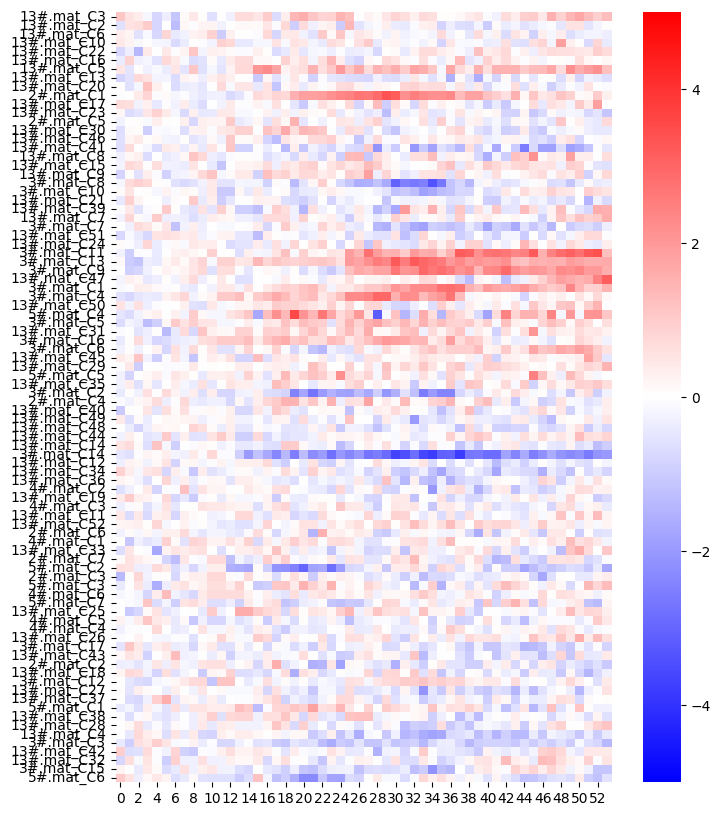

In [9]:
f, ax1 = plt.subplots(figsize=(8, 10), nrows=1)
sns.heatmap(np.array(cell_map), yticklabels = y, ax=ax1, vmax=5, vmin=-5, cmap='bwr')  ##
if is_save=='no':
    plt.savefig(img_path + '\\{}.jpg'.format(str(len(y)) + marker_list[0]), bbox_inches='tight')
    pd.DataFrame(np.array(cell_map),index=y).to_csv(img_path + '\\' + f'{marker_list[0]}-matrix' + '.csv')

#####眼动开始曲线
# xplot = (np.array(cell_map).shape[1]/(baseline+second))*baseline
# plt.plot([xplot,xplot],[0,95],color='white',linewidth=3,linestyle='--')

#########################
# plt.savefig(img_path + '/{}.jpg'.format(str(len(y)) + 'OKR'), bbox_inches='tight')
# plt.savefig(img_path + '/{}.jpg'.format(str(len(y)) +'R'), bbox_inches='tight')
# plt.savefig(img_path + '/{}.jpg'.format(str(len(y)) + 'NR'), bbox_inches='tight')
##########################
plt.show()

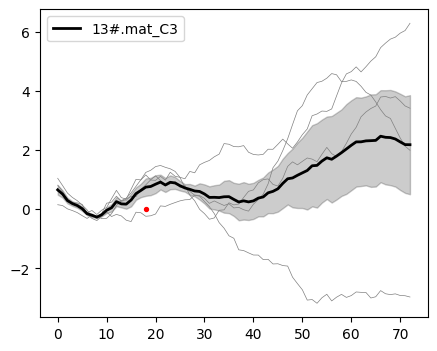

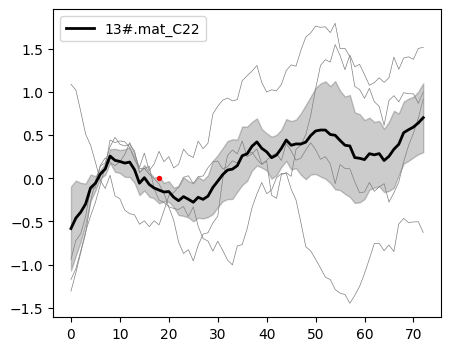

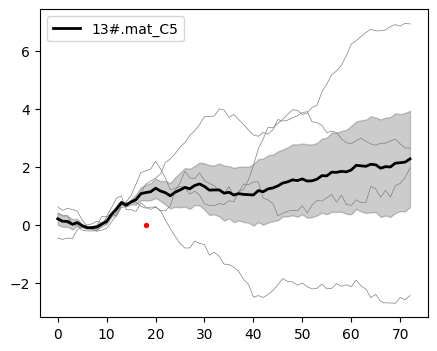

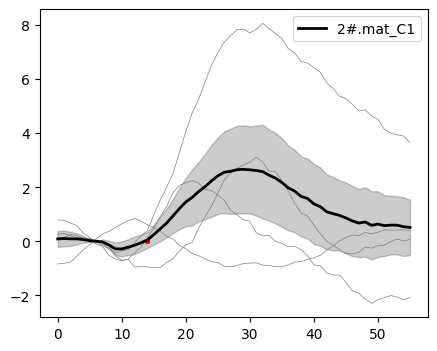

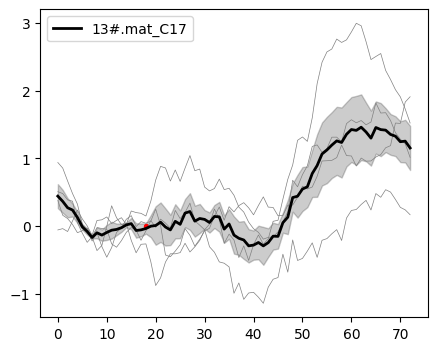

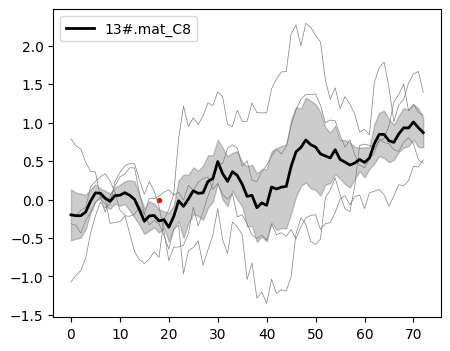

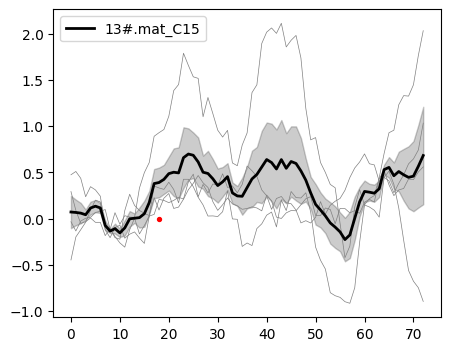

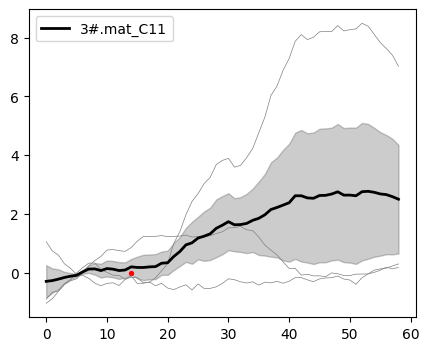

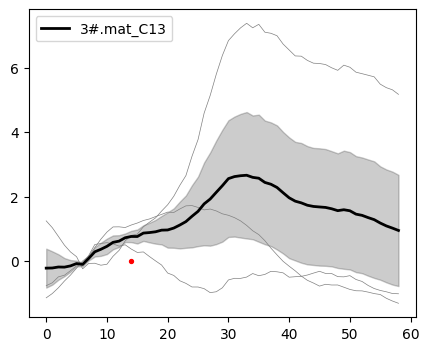

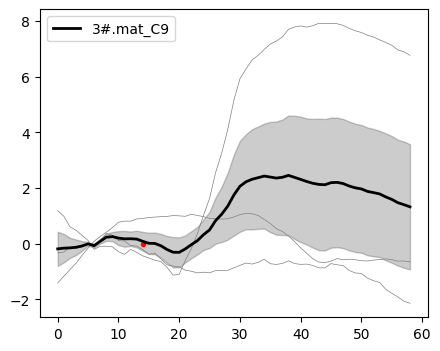

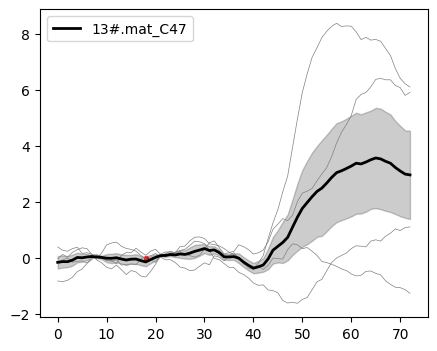

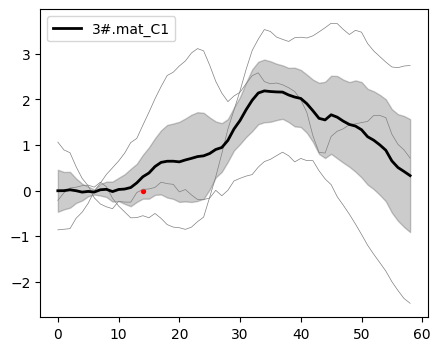

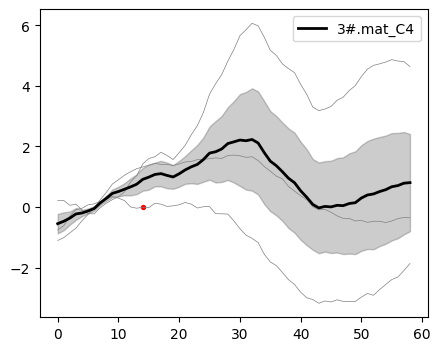

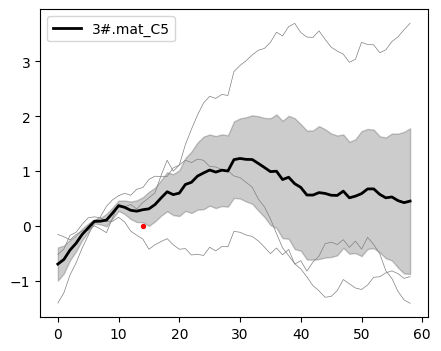

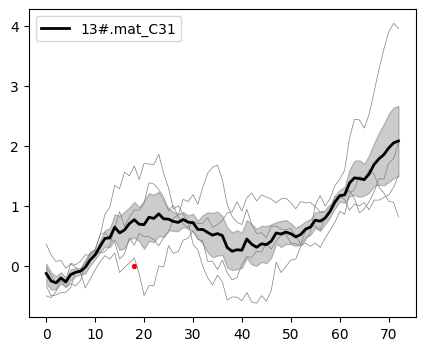

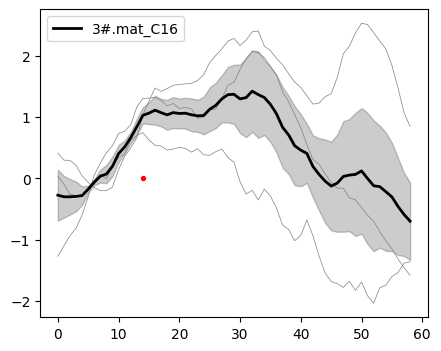

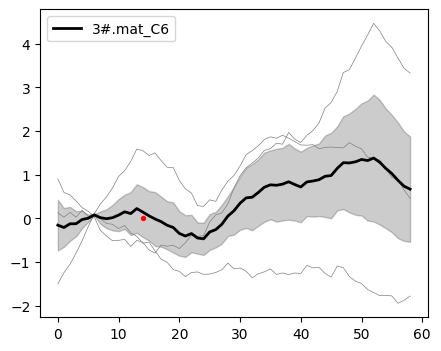

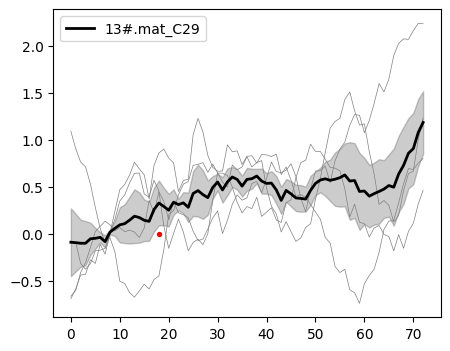

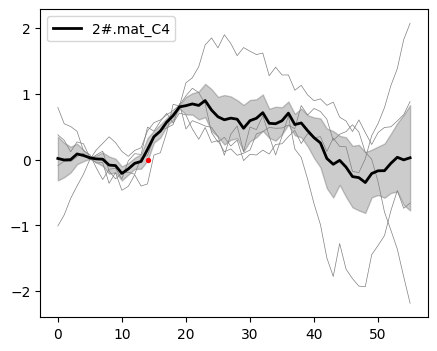

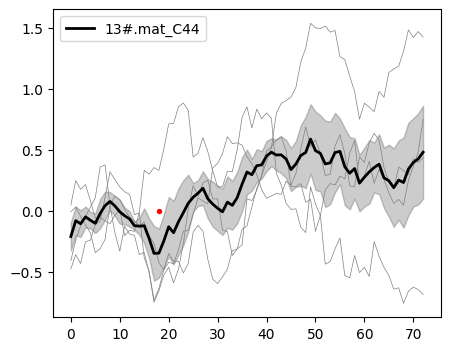

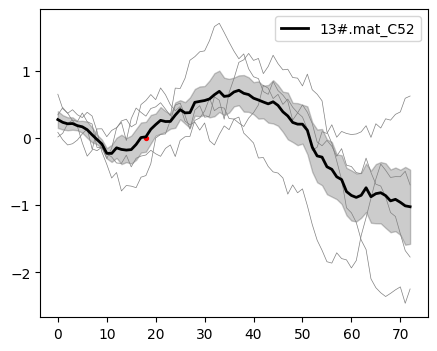

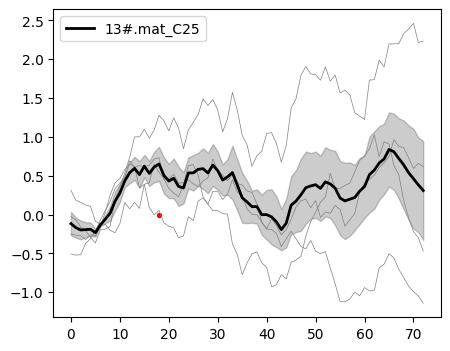

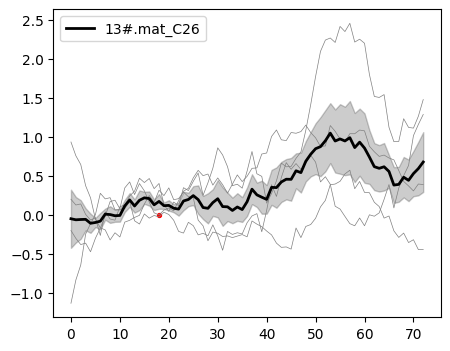

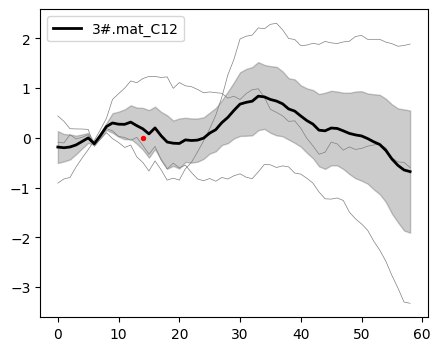

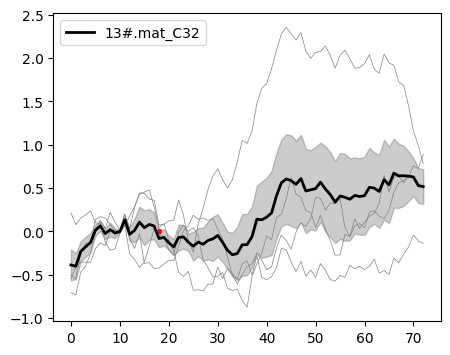

In [10]:
path=r'.\rawdata\network_analysis'
out_path=r'.\rawdata\out_put\Cell_EMrem'
EM_active=np.load(path+f'\\network_incluede_EM_active.npy')
for ind_i,cell_name in enumerate(y):
    if cell_name in EM_active:
        f, ax1 = plt.subplots(figsize=(5, 4), nrows=1)

        arr=np.array([smooth(i, 10) for i in cell_map_trial[ind_i]])

        # arr=np.array(cell_map_trial[ind_i])


        ave_ind_i=np.mean(arr,axis=0)
        std_ind_i=np.std(arr,axis=0)/(math.sqrt(len(arr)))
        plt.plot(arr.T,linewidth=0.5,color='gray')
        plt.plot(ave_ind_i,linewidth=2,color='black',label=cell_name)
        plt.fill_between(range(len(ave_ind_i)), ave_ind_i - std_ind_i, ave_ind_i+std_ind_i,
                    color='black', alpha=0.2)
        plt.scatter(len(ave_ind_i)//4,0,s=8,c='r')
        plt.legend()
        # sns.heatmap(np.array(cell_map_trial[ind_i]), yticklabels = y, ax=ax1, vmax=5, vmin=-5, cmap='bwr')
        plt.savefig(out_path+f'\\{cell_name}.pdf')
        plt.show()

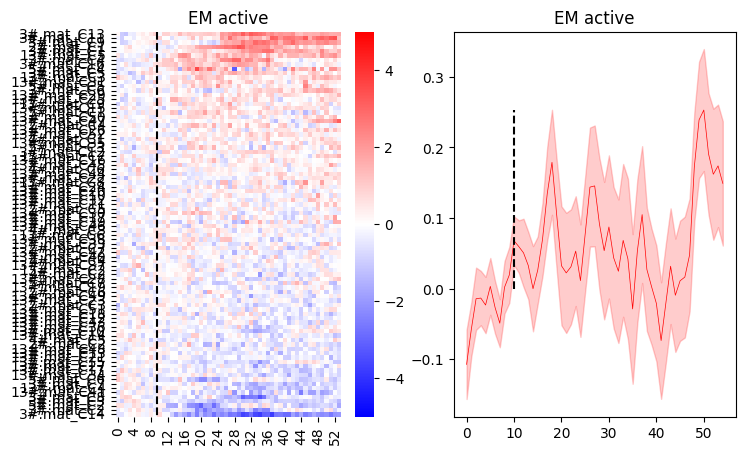

In [11]:
out_path=r'.\rawdata\out_put\Ca_acrossStage\REM'
EM_path=r'.\rawdata\out_put\Ca_acrossStage'
arr_EM=pd.read_csv(EM_path+'\\R-matrix.csv',index_col='cell_name')
arr=np.array(arr_EM)

len=arr.shape[1]
plt.figure(figsize=(8,5))
sort_val_EM1,sort_name1=sort_arr2(arr,arr_EM.index,len//5,len)

smooth_arr=np.array([smooth(i, 2) for i in arr])
Ave_val_EM=np.mean(smooth_arr,axis=0)
Sem_val_EM=np.array(smooth_arr.std(axis=0, ddof=1)) / (math.sqrt(arr.shape[0]))

plt.subplot(121)
sns.heatmap(sort_val_EM1, yticklabels =sort_name1, vmax=5, vmin=-5, cmap='bwr')  ##
plt.vlines(len//5,0,arr.shape[0],colors='black',linestyles='--');plt.title('EM active')

plt.subplot(122)

plt.plot(Ave_val_EM,linewidth=0.5,color='r',label='EM active')
plt.fill_between(range(Ave_val_EM.size),Ave_val_EM-Sem_val_EM,Ave_val_EM+Sem_val_EM,color='r', alpha=0.2)
plt.vlines(len//5,0,max(Ave_val_EM),colors='black',linestyles='--');plt.title('EM active')
plt.savefig(out_path+f'\\{os.path.basename(out_path)}.pdf')

plt.show()